# Stellar Mass Functions (SMFs)

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rc('text', usetex=True)

In [2]:
#data
Illustris_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_orig_11.2.hdf5'
TNG_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_tng75_11.2.hdf5'


### Song's SMF functions

In [3]:
def compute_smf_song(sm_array, volume, nb, sm_min, sm_max,
                smf_only=False, return_bins=False):
    """
    Parameters
    ----------
    sm_array: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^-3

    nb : number of bins

    sm_min : min of x axis

    sm_max : max of x axis

    Returns
    -------
    x : ndarray
        x axis of SMF in units of log10 M*

    smf : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    err : ndarray
        Poisson error
    """

    smf, bin_edges = np.histogram(sm_array, bins=nb,
                                  range=[sm_min, sm_max])

    # bin width in dex
    # !! Only works for constant bin size now
    mass_bin_width = (bin_edges[1] - bin_edges[0])

    # Normalize
    smf = (smf / volume / mass_bin_width)

    # Poison error
    if not smf_only:
        err = np.sqrt(smf)
        # Also normalize the err
        err = (err / volume / mass_bin_width)
        # X-axis
        x = bin_edges[:-1] + (mass_bin_width / 2.0)

    if not smf_only:
        if return_bins:
            return x, smf, err, bin_edges
        else:
            return x, smf, err
    else:
        # For bootstrap run
        return smf


def bootstrap_resample(X, n_boots=1000):
    """
    Bootstrap resample an array_like.
    Borrowed from: http://nbviewer.jupyter.org/gist/aflaxman/6871948

    Parameters
    ----------
    X : array_like
      data to resample
    n_boots : int, optional
      Number of bootstrap resamples
      default = 1000

    Results
    -------
    returns X_resamples
    """
    return np.vstack(
        X[np.floor(np.random.rand(len(X))*len(X)).astype(int)]
        for ii in np.arange(n_boots)).T


def bootstrap_smf_song(sm_array, volume, nb, sm_min, sm_max,
                  n_boots=1000, sm_err=None, resample_err=False):
    """
    Parameters
    ----------
    sm_array: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^-3

    nb : number of bins

    sm_min : min of x axis

    sm_max : max of y axis

    sm_err: ndarray, optional
        Array of stellar mass errors


    Returns
    -------
    x : ndarray
        x axis of SMF in units of log10 M*

    smf : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    err_poison : ndarray
        Poisson error

    smf_boots : ndarray
        Bootstrapped SMFs
    
    bins : edges of bins 
    """

    x, smf, err_poison, bins = compute_smf(sm_array, volume, nb,
                                           sm_min, sm_max,
                                           return_bins=True)

    if resample_err:
        msg = "Need to provide the error of stellar mass!"
        assert sm_err is not None, msg
        sm_boots = np.asarray(
            map(lambda mass, err: np.random.normal(mass, err, n_boots),
                sm_array, sm_err))
    else:
        sm_boots = bootstrap_resample(sm_array, n_boots=n_boots)

    smf_boots = np.vstack(
        compute_smf(sm_boots[:, ii], volume, nb, sm_min, sm_max, smf_only=True)
        for ii in range(n_boots)
    )
    
    return x, smf, err_poison, smf_boots, bins

## Modified functions

In [4]:
def compute_smf(log_masses, volume, n_bins, min_mass, max_mass):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
    """
    
    Phi,edg = np.histogram(log_masses,bins=n_bins, range=[min_mass, max_mass]) #Unnormalized histogram and bin edges
    dM    = edg[1] - edg[0]                 #Bin size
    m_centers   = edg[0:-1] + dM/2.           #Mass axis
    Phi   = Phi / float(volume) / dM             #Normalize to volume and bin size
    log_phi= np.log10(Phi) 

    # Poisson error
    err = np.sqrt(Phi)
    # Also normalize the err
    err = err / float(volume) / dM 
    
    return m_centers, Phi, err


def bootstrap_smf(log_masses, volume, n_bins, min_mass, max_mass,
                  n_boots=1000, sm_err=None, resample_err=False):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    sm_err: ndarray, optional
        Array of stellar mass errors


    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
        
    log_boot_err : ndarray
        log of Poisson error


    """

    m_centers, phi, err_poisson = compute_smf(log_masses, volume, n_bins, min_mass, max_mass)

    if resample_err:
        msg = "Need to provide the error of stellar mass!"
        assert sm_err is not None, msg
        sm_boots = np.asarray(map(lambda mass, err: np.random.normal(mass, err, n_boots),
                log_masses, sm_err))
    else:
        mass_boot_samples = bootstrap_resample(log_masses, n_boots=n_boots)

    phi_boots = np.vstack(compute_smf(mass_boot_samples[:, ii], volume, n_bins, sm_min, sm_max)[1] 
                              for ii in range(n_boots))
    
    #bootstrap error
    err_bootstrap=np.nanstd(phi_boots, axis=0)
    log_err_bootstrap=np.nanstd(np.log10(phi_boots[phi_boots != 0.0]), axis=0)
    
    
    
    return m_centers, phi, err_poisson, err_bootstrap, log_err_bootstrap, phi_boots

## get masses


In [32]:
# Illustris
f = h5py.File(Illustris_file, 'r')
cat_sh_mstars = np.array(f['cat_sh_mstar'])
f.close()
m_stars_illustris=np.log10(cat_sh_mstars)
mean_illustris=round(np.mean(m_stars_illustris),2)
median_illustris=round(np.median(m_stars_illustris),2)
std_illustris=round(np.std(m_stars_illustris),2)

#TNG
f = h5py.File(TNG_file, 'r')
cat_sh_mstars = np.array(f['cat_sh_mstar'])
f.close()
m_stars_tng=np.log10(cat_sh_mstars)
mean_tng=round(np.mean(m_stars_tng),2)
median_tng=round(np.median(m_stars_tng),2)
std_tng=round(np.std(m_stars_tng),2)


In [33]:
print max(m_stars_illustris), min(m_stars_illustris), len(m_stars_illustris)
print max(m_stars_tng), min(m_stars_tng), len(m_stars_tng)

12.4148511258 11.2015086567 339
12.4499482946 11.2016944807 235


## other parameters


In [49]:
volume_illustris=106.5**3 #Mpc^3
n_bins= 12
sm_min=11.2
sm_max=12.4

## SMFs

In [50]:
m_illustris, smf_illustris, err_illustris = compute_smf(m_stars_illustris, volume_illustris,n_bins, sm_min, sm_max)
m_tng, smf_tng, err_tng = compute_smf(m_stars_tng, volume_illustris,n_bins, sm_min, sm_max)

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10


## PLOTS


/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


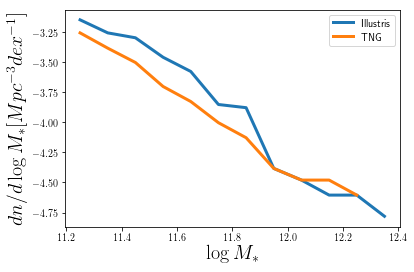

In [51]:
plt.plot(m_illustris,np.log10(smf_illustris), linewidth=3, label='Illustris')
plt.plot(m_tng,np.log10(smf_tng), linewidth=3, label='TNG')

plt.fill_between(m_illustris,np.log10(smf_illustris+10*err_illustris), np.log10(smf_illustris-10*err_illustris)) #Poisson error smaller than line
plt.fill_between(m_tng,np.log10(smf_tng+10*err_tng), np.log10(smf_tng-10*err_tng)) #Poisson error smaller than line

plt.xlabel(r'$\log{M_*}$', fontsize=20)
plt.ylabel(r'$dn / d\log{M_*}[Mpc^{-3} dex^{-1}]$', fontsize=20)
plt.legend()
plt.show()